# Vertical Slice Profile Plots from Paraview

In [2]:
%matplotlib inline
%reset -f
import fnmatch
import scipy.optimize as sp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os 
import glob
from IPython.display import set_matplotlib_formats
from scipy.optimize import curve_fit
import re
import datetime as dt 
import scipy.signal
import matplotlib.ticker as mticker
import math

In [74]:
%config InlineBackend.figure_formats = ['svg']
plt.rcParams['savefig.dpi'] = 350
plt.rcParams['figure.figsize'] = [3, 3]
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 1
plt.rcParams['figure.dpi'] = 100

In [253]:
main_path = 'C:\\Users\\super\\Dropbox\\Rice University\\501\\BL_Interactions\\'

fname = os.path.join(main_path,'[!m]*')
fileL = glob.glob(fname) #list of files
fileL = [file.replace(main_path,'') for file in fileL]
[fileL.remove(file) for file in fileL if '_' in file]; [fileL.remove(file) for file in fileL if 'Plume' in file];
ra_path = sorted (fileL, key = lambda x: (len (x), x))
ra_path = ['1e6','1e8','1e10']

Data = pd.DataFrame()
newColOrder = ['Ra','T','x','y','z','Vx','Vy','Vz']; Data = pd.DataFrame();

for i in range(len(ra_path)):    
    fname = os.path.join(main_path+ra_path[i]+'\\velo[!m]*.csv')
    fileL = glob.glob(fname) #list of files
#     for j in range(len(jName)):
#         [fileL.remove(file) for file in fileL if jName[j] in file]
    temp = pd.DataFrame()
    for file in fileL:
        a = fileL.index(file)
        b = pd.read_csv(file,header=0)
        b.rename(columns={0:a}, inplace=True)
        temp = pd.concat([temp,b],ignore_index=True)
    c = temp['temperature'].copy()
    c.values[:] = ra_path[i]
    temp.insert(0, "Ra", c)
    temp_mean = temp 
    my_data = temp
    my_data.rename(columns={'temperature':'T','Points:0':'z','Points:1':'x','Points:2':'y',\
                            0:'Ra','velocity:0':'Vz','velocity:1':'Vx','velocity:2':'Vy'},inplace=True)
    my_data = my_data[newColOrder]
    Data = pd.concat([Data,my_data],ignore_index=True)
Data['Ra'] = Data['Ra'].astype(float)
Data = Data.sort_values(by=['Ra','y','z'])
Data = Data.reset_index(drop=True)
vMag = np.sqrt(Data['Vx']**2 + Data['Vy']**2 + Data['Vz']**2)
Data.insert(8, "V", vMag)

In [254]:
Data_ave = Data.groupby(['Ra','x','z']).mean().reset_index()
newColOrder2 = ['Ra','x','z','T','V'];
Data_ave = Data_ave[newColOrder2];
Data_ave.rename(columns={'z':'Depth','T':'Temperature','V':'Velocity'},inplace=True)
Data_ave

,Ra,x,Depth,Temperature,Velocity
0,1.000000e+06,0.001,0.000,1.000000,737.865772
1,1.000000e+06,0.001,0.002,0.939452,738.384967
2,1.000000e+06,0.001,0.004,0.880671,739.468705
3,1.000000e+06,0.001,0.006,0.825220,740.905437
4,1.000000e+06,0.001,0.008,0.774284,742.599057
...,...,...,...,...,...
1537,1.000000e+10,0.999,0.992,0.476483,86784.752957
1538,1.000000e+10,0.999,0.994,0.476705,84802.814137
1539,1.000000e+10,0.999,0.996,0.453104,82988.008291
1540,1.000000e+10,0.999,0.998,0.452627,81566.873966


In [255]:
xU = Data_ave.x.unique()
lenX = len(xU)
RaU = Data_ave.Ra.unique()
lenRa = len(RaU)

data = [[] for i in range(lenRa)] #empty nested list

for i in range(lenRa):
    data[i] = Data_ave[Data_ave['Ra'] == RaU[i]]
    
data

[            Ra      x  Depth  Temperature    Velocity
 0    1000000.0  0.001  0.000     1.000000  737.865772
 1    1000000.0  0.001  0.002     0.939452  738.384967
 2    1000000.0  0.001  0.004     0.880671  739.468705
 3    1000000.0  0.001  0.006     0.825220  740.905437
 4    1000000.0  0.001  0.008     0.774284  742.599057
 ..         ...    ...    ...          ...         ...
 509  1000000.0  0.999  0.992     0.225750  742.567084
 510  1000000.0  0.999  0.994     0.174818  740.873126
 511  1000000.0  0.999  0.996     0.119369  739.436080
 512  1000000.0  0.999  0.998     0.060590  738.351770
 513  1000000.0  0.999  1.000     0.000000  737.831649
 
 [514 rows x 5 columns],
                Ra      x  Depth  Temperature     Velocity
 514   100000000.0  0.001  0.000     1.000000  3139.120866
 515   100000000.0  0.001  0.002     0.585124  3188.330131
 516   100000000.0  0.001  0.004     0.390934  3299.617117
 517   100000000.0  0.001  0.006     0.333732  3448.046058
 518   100000000.0

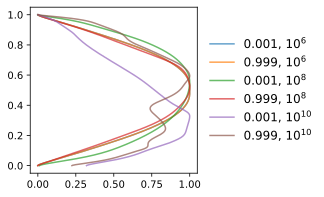

In [259]:
f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
fmt = mticker.FuncFormatter(g)
for j in range(lenRa):
    grouped = data[j].groupby(['x'])
    for i in xU:
        ra = grouped.get_group(0.001)['Ra'].values[0]
        lbl = str(i)+', '+ '{}'.format(fmt(ra))
        vv = grouped.get_group(i)['Velocity']
        velo = (vv-vv.min())/(vv.max()-vv.min())
        plt.plot(velo,grouped.get_group(i)['Depth'],label=lbl,alpha=0.7)
plt.legend(frameon=False,prop={'size': 12},loc='right', bbox_to_anchor=(1.75, 0.5));

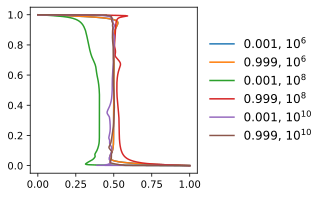

In [257]:
f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
fmt = mticker.FuncFormatter(g)
for j in range(lenRa):
    grouped = data[j].groupby(['x'])
    for i in xU:
        ra = grouped.get_group(0.001)['Ra'].values[0]
        lbl = str(i)+', '+ '{}'.format(fmt(ra))
        plt.plot(grouped.get_group(i)['Temperature'],grouped.get_group(i)['Depth'],label=lbl,alpha=0.7)
plt.legend(frameon=False,prop={'size': 12},loc='right', bbox_to_anchor=(1.75, 0.5));